# Toxic Spans Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import ast
from termcolor import colored
import string
from nltk.tokenize import word_tokenize 
from tqdm import trange

sns.set_style('darkgrid')

# For my jupyter theme
%config InlineBackend.print_figure_kwargs = {'facecolor':'white'}

![title](Images/pipeline.jpeg)

## Resumen

1. Quitando símbolos tóxicos (", espacios, !, etc) tenemos los siguientes resultados:
  - Hidden Markov Model: 0.321
  - Conditional Random Fields: 0.551
  - LSTM: 0.561 `(EMBEDDING_DIM = 32, HIDDEN_DIM = 32, EPOCHS = 10)`
2. Quitando símbolos tóxicos (", espacios, !, etc) y agregando como completamente tóxicos todos los que no tienen índices (los que viene como [ ]):
  - Hidden Markov Model: 0.299
  - Conditional Random Fields: 0.546
  - LSTM: 0.556 `(EMBEDDING_DIM = 32, HIDDEN_DIM = 32, EPOCHS = 10)`
  
3. Sin quitar símbolos tóxicos (", espacios, !, etc), es decir, dataset original:
  - Hidden Markov Model: 0.367
  - Conditional Random Fields: 0.501
  - LSTM: 0.535 `(EMBEDDING_DIM = 32, HIDDEN_DIM = 32, EPOCHS = 10)`
  
4. Sin quitar símbolos tóxicos (", espacios, !, etc) y agregando como completamente tóxicos todos los que no tienen índices (los que viene como [ ]):
  - Hidden Markov Model: 0.367
  - Conditional Random Fields: 0.501
  - LSTM: 0.535 `(EMBEDDING_DIM = 32, HIDDEN_DIM = 32, EPOCHS = 10)`
  
Para la LSTM lo mejor parece ser la opción 1. Lo mejor hasta ahora es con `(EMBEDDING_DIM = 20 HIDDEN_DIM = 20 EPOCHS = 25)` (0.581).

- [1. Exploración](#1)
  - [1.1 Mal etiquetados](#1.1)
- [2. Preprocesamiento](#2)
- [3. Modelos](#3)
  - [3.1 Hidden Markov Model](#3.1)
  - [3.2 Conditional Random Fields for Sequence Prediction](#3.2)
  - [3.3 LSTM](#3.3)
- [4. Evaluation](#4)

<a name = "1"></a>
# Exploración

In [2]:
from utils import color_toxic_words

In [3]:
train = pd.read_csv('Datos/tsd_train.csv', converters={'spans':ast.literal_eval})
test = pd.read_csv('Datos/tsd_trial.csv', converters={'spans':ast.literal_eval})

In [4]:
train.head()

spans  \
0  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...   
1                       [33, 34, 35, 36, 37, 38, 39]   
2                                       [0, 1, 2, 3]   
3          [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]   
4                       [32, 33, 34, 35, 36, 37, 38]   

                                                text  
0  Another violent and aggressive immigrant killi...  
1  I am 56 years old, I am not your fucking junio...  
2                  Damn, a whole family. Sad indeed.  
3  What a knucklehead. How can anyone not know th...  
4  "who do you think should do the killing?"\n\nA...

Veamos las secciones tóxicas de algunas oraciones:

In [5]:
for i,(index,text) in enumerate(train.values[0:5]):
    print('{} - '.format(i) + color_toxic_words(index, text) + '\n'*2)

0 - Another violent and aggressive immigrant killing a innocent and intelligent US Citizen.... Sarcasm


1 - I am 56 years old, I am not your fucking junior pal. What you are saying makes no sense. I don't know what you are basing this on. The cheap black market crap is still coming up from Mexican nationals, and the good stuff from BC and Humbolt.  The I5 corridor is still just as busy, and they are still making a ton of money. Nothing has really changed except that the legal market has made it easy for anyone of legal age to buy it.  And the legal market is controlled by corporate growers with million dollar facilities, or a co-op of smaller growers. The Federal government "war on drugs" really has no impact on the legal market in Oregon. I don't see any glutton of weed, whatever that means.


2 - Damn, a whole family. Sad indeed.


3 - What a knucklehead. How can anyone not know this would be offensive??


4 - "who do you think should do the killing?"

Anyone and everyone. This is a

<a name = "1.1"></a>
### ¿Mal etiquetados?

En algunas oraciones pone los espacios, comas y otros signos como caracteres tóxicos, hay que tener cuidado y al final concatenarlos si es que hay dos o más palabras tóxicas juntas. En la competencia paracen concatenarlos, pero no son consistententes en otras partes.

In [6]:
very_toxic = [i for i,x in zip(train.index, train['spans']) if len(x)>100][0:5]

for i,(index,text) in zip(very_toxic, train.values[very_toxic]):
    print('{} - '.format(i) + color_toxic_words(index, text) + '\n'*2)

158 - These idiotic studies are upsetting. Where is the information that is surprising. Any person in any walk of like could and would state these (study) results?


159 - [To say that juxtaposing and making the same a massacre and overtly implying that someone had something to do with that massacre is mere "negligence" is absolutely asinine]
You confer what is determined based upon the evidence is "extremely silly or stupid?"  Is that how you see federal courts and judges function?
[Those "journalists" knew one thing had nothing to do with the other]
What are you waiting for?  You better call Palin and tell her you have evidence that proves the "journalists" knew that the two were not connected because that'll prove there was actual malice.
Wait.  Why don't I hear you dialing?
[Your unrelated SCOTUS case is cute]
Let me get this straight.  The judge in this article used exactly the standard but you deem it as "unrelated?"
You sir, are in complete and completely irrational denial.  It 

Y hay otros que definitivamente están mal etiquetados, donde no ponen lenguaje tóxico donde realmente sí lo hay.

In [7]:
actually_toxic = [27, 60, 82, 134, 382]

for index,text in train.values[actually_toxic]:
    print(color_toxic_words(index, text) + '\n'*2)

The malignant narcissist, mentally deranged sociopath, bigot, rascist, disingenuous blowhard and pathological liar, has now certified himself as a fascist. How much longer before his GOP sycophants and suckees say, "Enough!", and demand this repugnant, excrement-spewing fool's ouster?


the is NO CONSENSUS you ignorant loser, NONE, nothing but debate, thousands of scientist do not agree period, we dont need to move from anything other than left wing stupidity like yours.


aa nadda showing the usual stupidity, its clowns like you that live outside reality, see pal canada needs the usa, the usa does not need us. , dont get me wrong, trudeau an ignorant child with no leadership skills doing real damage to canada with bs like carbon taxes...


Try reading my entire comment again, except slower, and then take a few moments for reflection, days if need be. If by then you still don't understand that the Trumpster is Putins bitch, you'll never get it.


You are just a stick buthole!




<a name = "2"></a>
## Preprocesamiento
Primero sería mejor tener las palabras tóxicas que los caracteres, también hay que tener cuidado cuando marcan un espacio o algún signo de puntuación como tóxico, al final sólo hay que concatenar si hay dos palabras tóxicas juntas (por hacer). También hay que pasar todo a minúscula y hacer el análisis en minúscula.

In [8]:
import string
from utils import remove_symbols, completely_toxic

In [9]:
text = 'fuck you idiot!!!'
index = np.arange(len(text)).tolist()

print(color_toxic_words(index, text))
print(color_toxic_words(remove_symbols(index, text), text))

fuck you idiot!!!
fuck you idiot!!!


Pondremos los que tienen [ ] como completamente tóxicos para ver qué sale.

In [10]:
# clean_spans = [completely_toxic(span, text) for (span, text) in zip(train['spans'], train['text'])]

# train['spans_clean'] = clean_spans

Ahora los que estaban como [ ] son completamente tóxicos.

In [11]:
# length_zero = [i for i,x in zip(train.index, train['spans']) if x == []][0:3]

# for i, (index,text,index_clean) in zip(length_zero, train.values[length_zero]):
#     print('{} - '.format(i) + color_toxic_words(index_clean, text) + '\n'*2)

Quitamos símbolos.

In [12]:
indices_clean = [remove_symbols(index, text) for index,text in 
                 zip(train['spans'], train['text'])]

train['spans_clean'] = indices_clean

Veamos como se ven si lo hacemos así:

In [13]:
very_toxic = [i for i,x in zip(train.index, train['spans']) if len(x)>100][0:3]

for i, (index,text,index_clean) in zip(very_toxic, train.values[very_toxic]):
    print('{} - '.format(i) + color_toxic_words(index, text))
    print('{} - '.format(i) + color_toxic_words(index_clean, text) + '\n'*2)

158 - These idiotic studies are upsetting. Where is the information that is surprising. Any person in any walk of like could and would state these (study) results?
158 - These idiotic studies are upsetting. Where is the information that is surprising. Any person in any walk of like could and would state these (study) results?


159 - [To say that juxtaposing and making the same a massacre and overtly implying that someone had something to do with that massacre is mere "negligence" is absolutely asinine]
You confer what is determined based upon the evidence is "extremely silly or stupid?"  Is that how you see federal courts and judges function?
[Those "journalists" knew one thing had nothing to do with the other]
What are you waiting for?  You better call Palin and tell her you have evidence that proves the "journalists" knew that the two were not connected because that'll prove there was actual malice.
Wait.  Why don't I hear you dialing?
[Your unrelated SCOTUS case is cute]
Let me get

También pasemos a minúscula el texto para el entrenamiento:

In [14]:
train['text'] = train['text'].apply(lambda x:x.lower())

<a name = "3"></a>
## Modelos

En la competencia usarán el F1 score para evaluar como sigue:

<blockquote cite="http://www.worldwildlife.org/who/index.html">
To evaluate the responses of a system participating in the challenge, we employ the $F_{1}$ score, as in [1]. Let system $A_i$ return a set $S^{t}_{A_{i}}$ of character offsets, for parts of the post found to be toxic. Let $G^{t}$ be the character offsets of the ground truth annotations of $t$. We compute the $F_{1}$ score of system $A_i$ with respect to the ground truth $G$ for post $t$ as follows, where $|·|$ denotes set cardinality.
    
$$ F_{1}^{t}(A_{i}, G) = \dfrac{2 \cdot P^{t}(A_{i}, G) \cdot R^{t}(A_{i}, G)}{P^{t}(A_{i}, G) + R^{t}(A_{i}, G)}$$
    
$$ P^{t}(A_{i}, G) = \dfrac{|S^{t}_{A_{i}} \cap S^{t}_{A_{i}}|}{|S^{t}_{A_{i}}|} $$
    
$$ R^{t}(A_{i}, G) = \dfrac{|S^{t}_{A_{i}} \cap S^{t}_{A_{i}}|}{|S^{t}_{G}|} $$    
    
If $S^{t}_{G}$ is empty for some post $t$ (no gold spans are given for $t$), we set $F_{1}^{t}(A_{i}, G)$ if $S^{t}_{A_{i}}$ is also empty, and $F_{1}^{t}(A_{i}, G) = 0$ otherwise. We finally average $F_{1}^{t}(A_{i}, G)$ over all the posts $t$ of an evaluation dataset $T$ to obtain a single score for system $A_{i}$.

</blockquote>

In [15]:
from utils import separate_words, get_index_toxic_words

In [16]:
# La siguiente función viene en el GitHub de la competencia.
def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1. if len(predictions) == 0 else 0.
    if len(predictions) == 0:
        return 0.
    predictions_set = set(predictions)
    gold_set = set(gold)
    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)
    return float(nom)/float(denom)

<a name = "3.1"></a>
### Hidden Markov Model

In [17]:
import nltk
from nltk.corpus import treebank
from nltk.tag import HiddenMarkovModelTrainer
from nltk.tokenize import word_tokenize

En nuestro caso debemos etiquetar en `toxic` y `non_toxic`.

In [18]:
train_data = []
for index, text in zip(train['spans_clean'], train['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append((token, 'toxic'))
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append((token, 'non_toxic'))
            
    train_data.append(tagged_tokens)

Entrenamos:

In [19]:
trainer = HiddenMarkovModelTrainer()
tagger_HMM = trainer.train_supervised(train_data)

Ahora hagamos algunos experimentos:

In [20]:
text = 'fucking piece of shit, suck my dick'
tagged_sentence = tagger_HMM.tag(word_tokenize(text))
toxic_index = get_index_toxic_words(text, tagged_sentence)

print(tagged_sentence)
print(color_toxic_words(toxic_index, text))

[('fucking', 'toxic'), ('piece', 'toxic'), ('of', 'toxic'), ('shit', 'toxic'), (',', 'non_toxic'), ('suck', 'toxic'), ('my', 'toxic'), ('dick', 'toxic')]
fucking piece of shit, suck my dick


In [21]:
text = 'have a nice day, my dear nigger'
tagged_sentence = tagger_HMM.tag(word_tokenize(text))
toxic_index = get_index_toxic_words(text, tagged_sentence)

print(tagged_sentence)
print(color_toxic_words(toxic_index, text))

[('have', 'non_toxic'), ('a', 'non_toxic'), ('nice', 'non_toxic'), ('day', 'non_toxic'), (',', 'non_toxic'), ('my', 'non_toxic'), ('dear', 'non_toxic'), ('nigger', 'toxic')]
have a nice day, my dear nigger


Veamos que score tenemos en el dataset de `test` y comparemos nuestras predicciones:

In [22]:
scores_HMM = []

for gold_index, text in test.values:
    tagged_sentence = tagger_HMM.tag(word_tokenize(text.lower()))   
    prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
    
    print(colored('Pred: ', color='cyan', attrs=['bold']) + 
          color_toxic_words(prediction_index, text))   
    print(colored('Gold: ', color='yellow', attrs=['bold']) + 
          color_toxic_words(gold_index, text) + '\n'*2)
    
    scores_HMM.append(f1(prediction_index, gold_index))

Pred: Because he's a moron and a bigot. It's not any more complicated than that.
Gold: Because he's a moron and a bigot. It's not any more complicated than that.


Pred: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.
Gold: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.


Pred: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...
Gold: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...


Pred: Trump Claimed that Russia will never invade the Ukraine, when Russia already has - how stupid can people be?
Gold: Trump Claimed that Russia w

Pred: You're wrong.  The delay between retirement and lobbying is nowhere near 7 years.  This law is specifically aimed at the SECDEF job.  The purpose of this separation is to ensure firm CIVILIAN leadership of the military.  Read the article.

You have no idea where I've worked.  Don't make ignorant statements.
Gold: You're wrong.  The delay between retirement and lobbying is nowhere near 7 years.  This law is specifically aimed at the SECDEF job.  The purpose of this separation is to ensure firm CIVILIAN leadership of the military.  Read the article.

You have no idea where I've worked.  Don't make ignorant statements.


Pred: Billy, are you a complete idiot, being thick headed or just not reading what people have been trying to tell you in response to your soapbox blathering.  A) Poor people without insurance need health care too. B) Planned Parenthood provides women's health care for free to anyone.  PP does these thru donations and grants from the States and Fed and Charity Found

Pred: "Wythe thinks Republican members of the House should settle their differences in caucus meetings — which are private."  That statement should scare the h*ll out of  any voter.  Another advocate for a state government functioning  behind closed doors is exactly who we do not need in the Alaska Legislature.  The  system she apparently adores (the secretive standing caucus system)has just about pounded this state into the ground.  Also, does she understand caucus membership is all about crushing any minority view and has little to do with party platforms and everything to do with the quid pro quo of trading toady behavior for spending in deals that are done behind closed doors?  Stupid is as stupid does..........
Gold: "Wythe thinks Republican members of the House should settle their differences in caucus meetings — which are private."  That statement should scare the h*ll out of  any voter.  Another advocate for a state government functioning  behind closed doors is exactly who we 

Pred: That's contradicted by the facts. First of all, Democrats have acknowledged the past and the party evolved to the anti-racist side, which prompted southern racists who used to constitute the Solid South for the party to migrate to the GOP, where the South now pretty much votes solidly for Republicans due to the GOP's adoption of the racist polices the Democrats used to push. If there are any remaining racists in the Democratic Party, the members will marginalize and push them out.

The Democratic Party of the 1800s, though, was the conservative party. They were not "leftist" at all.

Entitlements are not "slavery." That's just a silly remark, pre-packaged propaganda to demonize people who need help. Look at Ben Carson -- on public assistance and loans and public housing all his life until he made it on his own, and now he demonizes welfare. Bunch of hypocrites.
Gold: That's contradicted by the facts. First of all, Democrats have acknowledged the past and the party evolved to the 

Pred: Clinton lost because she's an unlikable incompetent hack who has  a long history of corruption, bribe-taking, lawbreaking, graft, greed, and who purposely handled classified documents on an illegal and vulnerable private server in her bathroom.  She didn't lose because of the Russians. She lost because of 30 years of lying, cheating, corrupt behavior and arrogant stupidity.
Gold: Clinton lost because she's an unlikable incompetent hack who has  a long history of corruption, bribe-taking, lawbreaking, graft, greed, and who purposely handled classified documents on an illegal and vulnerable private server in her bathroom.  She didn't lose because of the Russians. She lost because of 30 years of lying, cheating, corrupt behavior and arrogant stupidity.


Pred: Why is this black racist crap still on the G&M website?

I stopped talking to black people long ago because I was afraid for my life!!!!!
Since 80%-90% of all crime is by black people it kinda makes sense doesn't it.
Oh wait t

Pred: Apparently this nation isn't ready for a woman as president yet, even a highly qualified and intelligent woman with a lot of international diplomatic experience; but it's equally apparent this nation will accept an ignorant man with no governing, diplomatic or military experience, who fobs his business debts of on banks, partners and contractors, lies nonstop, tweets inanely at the wee hours, and has less attention span than a fruit fly.

A college education, as you know, doesn't even guarantee literacy. Most of those voters probably had business degrees, which means, social and economic conservative mixed with social pretenses, bigotry toward working people, and a distrust or disrespect toward women. This election was an eye-opener for me.
Gold: Apparently this nation isn't ready for a woman as president yet, even a highly qualified and intelligent woman with a lot of international diplomatic experience; but it's equally apparent this nation will accept an ignorant man with no g

Pred: Great commentary. How did the Party of Lincoln deteriorate into the fraudster Party of Trump? How can a man who pretty much shamelessly lies every time he opens his mouth claim Hillary is untruthful (yes she occasionally lies too). How can a man born rich who markets himself as a rich elitist and a reputation sticking it to contractors and investors, claim to represent the middle class? How can a schoolyard bully claim to be a great negotiator?  Trump supporters, have you gone completely nuts?
Gold: Great commentary. How did the Party of Lincoln deteriorate into the fraudster Party of Trump? How can a man who pretty much shamelessly lies every time he opens his mouth claim Hillary is untruthful (yes she occasionally lies too). How can a man born rich who markets himself as a rich elitist and a reputation sticking it to contractors and investors, claim to represent the middle class? How can a schoolyard bully claim to be a great negotiator?  Trump supporters, have you gone complet

Pred: Yup he is a pathological liar just like your Queen Hillary and Bill Clinton.  Man you need to move on in life.  If you let this loss eat you alive you will probably be jumping off a bridge soon.  get on with your life and accept the results.  I have never seen such a sore loser.
Gold: Yup he is a pathological liar just like your Queen Hillary and Bill Clinton.  Man you need to move on in life.  If you let this loss eat you alive you will probably be jumping off a bridge soon.  get on with your life and accept the results.  I have never seen such a sore loser.


Pred: It explains why he is a billionaire and married to a supermodel and you're just a random idiot on the internet.
Gold: It explains why he is a billionaire and married to a supermodel and you're just a random idiot on the internet.


Pred: Chin is a complete moronski.
Gold: Chin is a complete moronski.


Pred: Except the darn population keeps rising.
Gold: Except the darn population keeps rising.


Pred: Awful comment


Pred: You are so correct SKL - the left makes such a big deal about so called "bullying" yet it's perfectly fine if they do it.  They're such disgraceful hypocrites.
Gold: You are so correct SKL - the left makes such a big deal about so called "bullying" yet it's perfectly fine if they do it.  They're such disgraceful hypocrites.


Pred: I am a firm believer that stupid individuals cause much more harm than malicious individuals.

This has very strong support in academic research. See the following paper:

_The Basic Laws of Human Stupidity_ at

https://trusttheneighbors.files.wordpress.com/2016/05/blhs.pdf

-- Paul
Gold: I am a firm believer that stupid individuals cause much more harm than malicious individuals.

This has very strong support in academic research. See the following paper:

_The Basic Laws of Human Stupidity_ at

https://trusttheneighbors.files.wordpress.com/2016/05/blhs.pdf

-- Paul


Pred: 151 years ago economist, philosopher and Liberal Member of Parliament John Stu

Pred: Where do you dig this crap up? And that is what it is without context.
Gold: Where do you dig this crap up? And that is what it is without context.


Pred: Her life is turned upside down and your best is calling her stupid? Please tell us where you graduated from med school.
Gold: Her life is turned upside down and your best is calling her stupid? Please tell us where you graduated from med school.


Pred: So many loser Sens fans with lip quiver! HAHAHA!
Gold: So many loser Sens fans with lip quiver! HAHAHA!


Pred: No, the biggest difference is that Trump is a sulky boy while Putin is a vicious sociopath. Trump will sneer at you in tweets. Putin will have your children killed.
Gold: No, the biggest difference is that Trump is a sulky boy while Putin is a vicious sociopath. Trump will sneer at you in tweets. Putin will have your children killed.


Pred: Had no idea there were so many stinkin, rotten, douchebag democrats in our great state....wow....
Gold: Had no idea there were s

Pred: And power consumption will only increase after marijuana is decriminalized.  Those plants is our basements would wilt if we shut the lights off.   Suck and blow Justin.
Gold: And power consumption will only increase after marijuana is decriminalized.  Those plants is our basements would wilt if we shut the lights off.   Suck and blow Justin.


Pred: the lunatic hating left wingers are out it force today, spewing thier utter stupidity that thinks comey did anything to trump when all he did was admit comey did a leak, still no evidence at all about any russia bs, no obstruction by his own admission, nada, not one thing anyone can attach a criminal statute too, , but the lunatic left living in thier complete stupidity still thinks trump is done, ha ha ha what a bunch of uneducated sheep
Gold: the lunatic hating left wingers are out it force today, spewing thier utter stupidity that thinks comey did anything to trump when all he did was admit comey did a leak, still no evidence at al

Pred: Hey Mateo, ever been to Texas? It's the second most diverse state. Lots of black and Hispanic police officers. What a stupid press release.
Gold: Hey Mateo, ever been to Texas? It's the second most diverse state. Lots of black and Hispanic police officers. What a stupid press release.


Pred: "Homosexual men define their own masculinity."  

It's BS statements like that that invite ridicule.  If you insist on entering the fray in that manner, don't complain when the truth kicks you right in the hiney.  Simply put, it is the antithesis of masculinity for a man to --- I'll remain polite --- have another man sexually.
Gold: "Homosexual men define their own masculinity."  

It's BS statements like that that invite ridicule.  If you insist on entering the fray in that manner, don't complain when the truth kicks you right in the hiney.  Simply put, it is the antithesis of masculinity for a man to --- I'll remain polite --- have another man sexually.


Pred: And was the Oklahoma bombing

Pred: "Salazar said there was no “bad intent” on the part of DiStefano, George or MacIntyre, but rather “mistakes” were made."

Huh! I learned a long time ago in the principle of CYA. When something like this happened in my area of responsibility, I was reaching out to legal and HR to make sure things were handled by the book . .  no looking away.

No bad intent? Don't give me that . . . at best it was gross stupidity coupled with a severe case of willful blindness.
Gold: "Salazar said there was no “bad intent” on the part of DiStefano, George or MacIntyre, but rather “mistakes” were made."

Huh! I learned a long time ago in the principle of CYA. When something like this happened in my area of responsibility, I was reaching out to legal and HR to make sure things were handled by the book . .  no looking away.

No bad intent? Don't give me that . . . at best it was gross stupidity coupled with a severe case of willful blindness.


Pred: This is disgraceful. For the dems  to use this fam

Pred: I don't think the writer of this piece of shit knows what a "white savior complex" is if the jackass did know what it meant he would realize he used it incorrectly, also asians are pretty damn white so using a pathetic virtue signal like that is doesn't apply here, stop cowtowing to the Far Left you little bitch you're white stop self hating just because people have told you to. If you review a film review the damn film don't review society you virtue signaling cunt.
Gold: I don't think the writer of this piece of shit knows what a "white savior complex" is if the jackass did know what it meant he would realize he used it incorrectly, also asians are pretty damn white so using a pathetic virtue signal like that is doesn't apply here, stop cowtowing to the Far Left you little bitch you're white stop self hating just because people have told you to. If you review a film review the damn film don't review society you virtue signaling cunt.


Pred: What a disaster!!! An Islam plant..l

Pred: You prove my point that it is a matter of personal judgement, you don't think that 'certain' person is a troll, I do think he is. I'll grant you he is ostensibly civil but his aim is to pour scorn on and subtly abuse orthodox Catholic posters. Yet for all that I do not flag him nor do I mute him just because I think his comments are generally pathetic.
Gold: You prove my point that it is a matter of personal judgement, you don't think that 'certain' person is a troll, I do think he is. I'll grant you he is ostensibly civil but his aim is to pour scorn on and subtly abuse orthodox Catholic posters. Yet for all that I do not flag him nor do I mute him just because I think his comments are generally pathetic.


Pred: He should have died in Afghanistan and be with Satan now--but we are stuck with this deviant killer.
Gold: He should have died in Afghanistan and be with Satan now--but we are stuck with this deviant killer.


Pred: Laughable.   The great negotiator  can't keep employee

Pred: Just stop.  The people who did that with Obama were jerks and morons, not representing the "right".  Same with this trashy mess.  I know many liberal types who are disgusted by the ever-annoying Ms. Griffin.  

Not everything breaks out along party lines and every sane person better hope we never get to that point. If we do, we lose our moral compass and any concept of right vs wrong.
Gold: Just stop.  The people who did that with Obama were jerks and morons, not representing the "right".  Same with this trashy mess.  I know many liberal types who are disgusted by the ever-annoying Ms. Griffin.  

Not everything breaks out along party lines and every sane person better hope we never get to that point. If we do, we lose our moral compass and any concept of right vs wrong.


Pred: Kim doesn't have what it takes to fire a missile
at the US. Now pile on more sanctions until his
people turn on him and put him and family to
death.
Gold: Kim doesn't have what it takes to fire a missile


Pred: Im pretty sure wage growth is statistical for gentrification. Politics?!? Really people need to stop fantasizing about their popularity contests and realize politicians are scum.
Gold: Im pretty sure wage growth is statistical for gentrification. Politics?!? Really people need to stop fantasizing about their popularity contests and realize politicians are scum.


Pred: Clinton "Queen of the Useful Idiots" is a serial woman berater, misogynist, woman abuser, and enforcer for her sick convenience marriage dolt so called husband.  And yet these libbernuts yap about feminism!  What a world, What a world, said the wicked witch!
Gold: Clinton "Queen of the Useful Idiots" is a serial woman berater, misogynist, woman abuser, and enforcer for her sick convenience marriage dolt so called husband.  And yet these libbernuts yap about feminism!  What a world, What a world, said the wicked witch!


Pred: Shawn Spicer is dishonest scum.

He spent months trying but failing at defending the indef

Gold: We have people who use the handle "TRUMP IS SIMPLY A VACUOUS BUFFOON And a petty con man. And a traitor", and THIS is considered acceptable and meeting the "civility" standard but the following is not????

"This is another Trump game ... sort of like tweeting "COFEFE". He was playing with Comey so that Comey wasn't sure how far he could carry any lies. Trump has probably been enjoying watching the liberal media twisting themselves in knots over yet another innocent comment (he never said any tapes were made, only that Comey better hope there weren't any)!! Good on ya' Mr. President ... keep playing with these liberal media morons until the world finally sees the buffoons they are!!!"

Really??????????

The "civility" standards are a joke!!!!


Pred: Thank you FBI, President Obama and others for your caution and sense of fair play; however, what good does it do us to do nothing until we obtain evidence worthy of impressing a judge or jury in a United States court of law where you 

Pred: Ummm...why are you so obsessed with Johann? You seem insecure. Kinda pathetic dude.
Gold: Ummm...why are you so obsessed with Johann? You seem insecure. Kinda pathetic dude.


Pred: You, sir, are an idiot.
Gold: You, sir, are an idiot.


Pred: Save it. Damn the developers.
Gold: Save it. Damn the developers.


Pred: Well we know he is a wanker
Gold: Well we know he is a wanker


Pred: Look: the village idiot!
Gold: Look: the village idiot!


Pred: It can also be used satirically, to poke fun at the stupid and ignorant. I like to do that now and then.
Gold: It can also be used satirically, to poke fun at the stupid and ignorant. I like to do that now and then.


Pred: This is what's dreadfully wrong with our so-called judicial system; criminals can do harm and get away with it.  I don't  care if the spouse went along to get along with her husband.  Children were sexually abused and didn't even know that the sexual predator was planning to kill them.  The spouse deserves a minimum 

Pred: If the pedestrians are too stupid, too arrogant, too self-absorbed in themselves or their cell phones or their companions to use the devices designed to keep them alive with minimal effort, I don't have any sympathy for them whatsoever.

I will have sympathy for the person who couldn't avoid them, just like the young man who couldn't avoid the 'impaired' guy on the bicycle after dark with no lights.  The first driver missed him, the second couldn't.  

The driver in this instance deserves sympathy; the bicyclist....

Your idiots who can't push a little button.....the same as the bicyclist.
Gold: If the pedestrians are too stupid, too arrogant, too self-absorbed in themselves or their cell phones or their companions to use the devices designed to keep them alive with minimal effort, I don't have any sympathy for them whatsoever.

I will have sympathy for the person who couldn't avoid them, just like the young man who couldn't avoid the 'impaired' guy on the bicycle after dark with

Pred: my god you ignorant left wingers will live in complete stupidity every day with such nonsense.  it was obama that didnt care for people only his legacy when he made insurance so unafordable those millions he added could never use the insurance given the out of site deductables
Gold: my god you ignorant left wingers will live in complete stupidity every day with such nonsense.  it was obama that didnt care for people only his legacy when he made insurance so unafordable those millions he added could never use the insurance given the out of site deductables


Pred: So bad mouthing minorities now , eh?
You dems are such hypocrites.
Gold: So bad mouthing minorities now , eh?
You dems are such hypocrites.


Pred: You are well aware that 90% of Catalans voted for Independence.

If you didn’t vote, it’s your own fault and no one cares what you think because you are a coward.

Suspect if 99.9% had voted for Independence, you would still be asking, “What about the 0.1%?”

Congrats to the 

Pred: Because people tend to be emotion-driven idiots which is why politicians and activists are always aiming at your heartstrings.
Gold: Because people tend to be emotion-driven idiots which is why politicians and activists are always aiming at your heartstrings.


Pred: You lie, and in a sniveling tone. I bring up Hillary, because Mr. Hahn would have her and her Islamic friends run the U.S. Sad, and pathetic.
Gold: You lie, and in a sniveling tone. I bring up Hillary, because Mr. Hahn would have her and her Islamic friends run the U.S. Sad, and pathetic.


Pred: Yeah, all you knuckleheads, go ahead & make MYYYYY Day!!!! It will be HYYYUUUGE, just like all of my HYYYUUUGE casino bankruptcies. Getting all other's to take the fault and financial fall for me. By losing MONEY, THIS TRUMP,  will have the United States, filing for bankruptcy within 365 days of taking office. When I refuse to let the Treasury Secretary pay the interest on the amount of debt we are beholden to them [Chinese]

Pred: No, they as anti-American as it gets. They are nazis. Instead of secede, they should be rounded up and kicked out of the United States. They are the enemies of democracy and human rights. Garbage.
Gold: No, they as anti-American as it gets. They are nazis. Instead of secede, they should be rounded up and kicked out of the United States. They are the enemies of democracy and human rights. Garbage.


Pred: There are localized outbreaks of 'gun violence' in epidemic proportions.

Criminal gangs of specific ethnicities:  Black, Hispanic and Asian respectively.

That is not a racist comment, either.  Just a recitation of the facts of life...and death.
Gold: There are localized outbreaks of 'gun violence' in epidemic proportions.

Criminal gangs of specific ethnicities:  Black, Hispanic and Asian respectively.

That is not a racist comment, either.  Just a recitation of the facts of life...and death.


Pred: What A__hole came up with this?    gotta be a damn Democrate
Whoever thinks he

Pred: And do you define "solid proof'? Outside of mathematics and physics (correct me if there are others) you can never have definitive 'proof' of anything.

You can have evidence and in this case there seems to be many converging threads of evidence. The question is, why is all this evidence appearing in the political discourse now? Some people think that it's because Obama's a sore loser, or the intelligence communities want to embarass Trump, or they are simply inept. 

My theory is simpler. There is evidence because the attempt to influence the election was real and the dividends the Russians will accrue as a result are considerable. They aren't stupid.
Gold: And do you define "solid proof'? Outside of mathematics and physics (correct me if there are others) you can never have definitive 'proof' of anything.

You can have evidence and in this case there seems to be many converging threads of evidence. The question is, why is all this evidence appearing in the political discourse n

In [23]:
print('HMM score: {:.3f}'.format(np.mean(scores_HMM)))

HMM score: 0.321


<a name = "3.2"></a>
### Conditional Random Fields for Sequence Prediction

In [24]:
from itertools import chain
from nltk import pos_tag
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn
import pycrfsuite
from tqdm import tqdm
from utils import word2features, sent2features, sent2labels, sent2tokens, token_postag_label

In [25]:
train_data_crf = []
for text, toxic_tags in tqdm(zip(train['text'], train_data), total=len(train_data)):
    pos_tags = token_postag_label(text.lower())
    sentence = []
    for x,y in zip(pos_tags, toxic_tags):
        sentence.append(x + (y[1],))
        
    train_data_crf.append(sentence)

100%|██████████| 7939/7939 [00:09<00:00, 808.72it/s]


In [26]:
X_train = [sent2features(s) for s in train_data_crf]
y_train = [sent2labels(s) for s in train_data_crf]

trainer = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

Probablemente sea buena idea hacer una búsqueda de los mejores hiperparámetros, ya que el performance cambia significativamente dependiendo de los hiperparámetros.

In [27]:
trainer.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 0.01,  # coefficient for L2 penalty
    'max_iterations': 100,  # stop earlier
    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

# trainer.params()

In [28]:
%time trainer.train('toxic_speech.crfsuite')

tagger_crf = pycrfsuite.Tagger()
tagger_crf.open('toxic_speech.crfsuite')

CPU times: user 12.7 s, sys: 0 ns, total: 12.7 s
Wall time: 12.7 s


In [29]:
test_data_crf =  []
for text in tqdm(test['text']):
    pos_tags = token_postag_label(text.lower())
    sentence = []
    for x in pos_tags:
        sentence.append(x + ('',))
        
    test_data_crf.append(sentence)

100%|██████████| 690/690 [00:00<00:00, 875.47it/s]


In [30]:
scores_CRF = []

for text_crf,(gold_index,text) in zip(test_data_crf, test.values):
    words = [x[0] for x in text_crf]
    tags = tagger_crf.tag(sent2features(text_crf))
    
    tagged_sentence = [(word, tag) for word,tag in zip(words,tags)]
    prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
    
    print(colored('Pred: ', color='cyan', attrs=['bold']) + 
          color_toxic_words(prediction_index, text))   
    print(colored('Gold: ', color='yellow', attrs=['bold']) + 
          color_toxic_words(gold_index, text) + '\n'*2)
    
    scores_CRF.append(f1(prediction_index, gold_index))

Pred: Because he's a moron and a bigot. It's not any more complicated than that.
Gold: Because he's a moron and a bigot. It's not any more complicated than that.


Pred: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.
Gold: How about we stop protecting idiots and let nature add some bleach to the gene pool. We can always submit their names for the Darwin awards.


Pred: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...
Gold: If people  were  smart, they would  Boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...


Pred: Trump Claimed that Russia will never invade the Ukraine, when Russia already has - how stupid can people be?
Gold: Trump Claimed that Russia w

Pred: They have the White House, the House, and the Senate and they can't govern themselves out of a paper bag.  But hey, keep ginning up the race baiting cause that'll get the twice removed judge into office.  Maybe that idiot will help you.
Gold: They have the White House, the House, and the Senate and they can't govern themselves out of a paper bag.  But hey, keep ginning up the race baiting cause that'll get the twice removed judge into office.  Maybe that idiot will help you.


Pred: Anti-vaccine fools reap what you sow.
Gold: Anti-vaccine fools reap what you sow.


Pred: Idiot........
Gold: Idiot........


Pred: "It seems almost everyone is falling for it."

It's the same crap, different packaging. It drives me crazy that people fall for that just because of Politics.

Russians also made the ref overturn the Sanders catch then they hashtagged it to anger Bronco fans even more. 

You can use Russia for any excuse these days. All the ills of America can be blamed on yet another ent

Gold: obviously the woman has not seen the video of hillarys lies, its about 20 minutes long on youtube. anybody voting for her after watching it is pure stupid.


Pred: Just stop.  The people who did that with Obama were jerks and morons, not representing the "right".  Same with this trashy mess.  I know many liberal types who are disgusted by the ever-annoying Ms. Griffin.  

Not everything breaks out along party lines and every sane person better hope we never get to that point. If we do, we lose our moral compass and any concept of right vs wrong.
Gold: Just stop.  The people who did that with Obama were jerks and morons, not representing the "right".  Same with this trashy mess.  I know many liberal types who are disgusted by the ever-annoying Ms. Griffin.  

Not everything breaks out along party lines and every sane person better hope we never get to that point. If we do, we lose our moral compass and any concept of right vs wrong.


Pred: Kim doesn't have what it takes to fire a

Pred: Idiot security guard firing his weapon with people nearby. There must be video somewhere...So, who's in charge of airport video, Securitas?..
Gold: Idiot security guard firing his weapon with people nearby. There must be video somewhere...So, who's in charge of airport video, Securitas?..


Pred: Amen Brother Richard ... what the heck is WRRROOOOONNNNGGG as Cheetolini would say with these whacked out hillbilly Republicans that voted for this MONSTER ...
Gold: Amen Brother Richard ... what the heck is WRRROOOOONNNNGGG as Cheetolini would say with these whacked out hillbilly Republicans that voted for this MONSTER ...


Pred: You're stupid want to get slander and deformation chargers thrown on your ass? Unless your the judge or were one of the people involved how do you really know what went down, Christopher is family, not a criminal. Quit hiding behind your little computer screen typing away like you know what your talking about you pathetic pansey!
Gold: You're stupid want to ge

In [31]:
print('CRF score: {:.3f}'.format(np.mean(scores_CRF)))

CRF score: 0.551


<a name = "3.3"></a>
### LSTM

Estamos basándonos en [Sequence models and LSTM networks](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html). 

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.cuda.current_device(), torch.cuda.get_device_name(0)

(0, 'GeForce RTX 2070')

In [33]:
if torch.cuda.is_available():  
    dev = 'cuda:0' 
else:  
    dev = 'cpu'
    
print(dev)

cuda:0


In [34]:
train_data = []
for index, text in zip(train['spans_clean'], train['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    train_data.append((tokens, tagged_tokens))

In [35]:
test_data = []
for index, text in zip(test['spans'], test['text']):
    toxic_words = [text[i[0]:i[-1]+1] for i in separate_words(index) if len(index) > 0]
#     print(toxic_words)
    
    tokens = word_tokenize(text)
    tagged_tokens = []
    
    for token in tokens:
        if token in toxic_words:
            tagged_tokens.append('toxic')
            # Removemos en caso de que se repita posteriormente pero esté como 'non_toxic'
            toxic_words.remove(token) 
        else:
            tagged_tokens.append('non_toxic')
            
    test_data.append((tokens, tagged_tokens))

In [36]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix.get(w, 0) for w in seq]      # Si no está que lo ponga como 'UNK'
    return torch.tensor(idxs, dtype=torch.long, device=dev)

In [37]:
word_to_ix = {'UNK': 0}

for sent, tags in train_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
            
tag_to_ix = {"non_toxic": 0, "toxic": 1}  # Assign each tag with a unique index

Creamos el modelo:

In [38]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

Entrenamos el modelo:

In [39]:
def tagger_LSTM(text):
    ix_to_tag = {0: 'non_toxic', 1: 'toxic'}
    words = word_tokenize(text.lower())
    
    with torch.no_grad():
        inputs = prepare_sequence(words, word_to_ix)
        tag_scores = model(inputs)
        tags = [np.argmax(x.cpu().numpy()) for x in tag_scores]

        tagged_sentence = [(word, ix_to_tag[tag]) for word,tag in zip(words, tags)]

    return tagged_sentence

In [40]:
def f1_scores(df):
    scores_LSTM = []
    for gold_index, text in df.values:
        tagged_sentence = tagger_LSTM(text)   
        prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
        scores_LSTM.append(f1(prediction_index, gold_index))
        
    return np.mean(scores_LSTM)

In [41]:
def plot_loss_and_score(train_loss, test_loss, f1_scores_train, f1_scores_test):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

    ax0.plot(np.arange(1, len(train_loss) + 1), train_loss, marker='o', label='train_loss')
    ax0.plot(np.arange(1, len(test_loss) + 1), test_loss, marker='o', label='validation loss')
    ax0.set_xlabel('Epochs')
    ax0.set_ylabel('Loss')
    ax0.legend()

    ax1.plot(np.arange(1, len(f1_scores_train) + 1), f1_scores_train, 
             marker='o', label='f1 score in train')
    ax1.plot(np.arange(1, len(f1_scores_test) + 1), f1_scores_test, 
             marker='o', label='f1 score in test')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('F1 score')
    ax1.legend()

    plt.show()

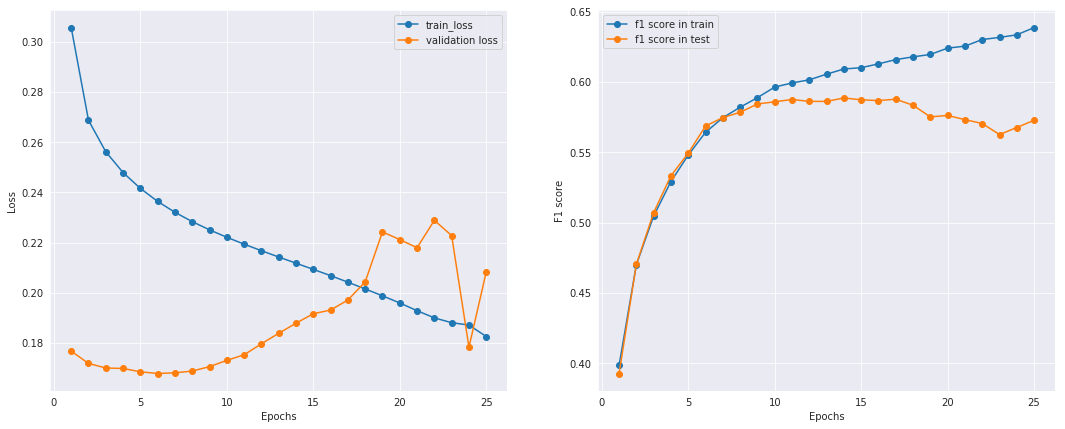

100%|██████████| 25/25 [13:18<00:00, 31.93s/it]


In [66]:
# Deben ir en la misma celda donde se entrena, de lo contrario no fija la semilla
torch.manual_seed(100)
# np.random.seed()

# These will usually be more like 32 or 64 dimensional.
EMBEDDING_DIM = 20
HIDDEN_DIM = 20
EPOCHS = 25

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
model.to(torch.device(dev)) # Lo mueve a la GPU, en caso de que haya
# model.cuda()              # Pasa todo a la GPU, da error si no hay GPU        
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

with torch.no_grad():
    inputs = prepare_sequence(train_data[0][0], word_to_ix)
    tag_scores = model(inputs)
#     print(tag_scores)
 
train_loss = []
test_loss = []
f1_scores_train = []
f1_scores_test = []

for epoch in trange(EPOCHS): 
    train_val = 0.0
    test_val = 0.0
    for sentence, tags in train_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        train_val += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss.append(train_val/len(train_data))
                
    for sentence, tags in test_data:
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)     
        
        tag_scores = model(sentence_in)
        
        loss_test = loss_function(tag_scores, targets)
        test_val += loss_test.item()
        
    test_loss.append(test_val/len(test_data))
    
    f1_scores_train.append(f1_scores(train[['spans', 'text']]))
    f1_scores_test.append(f1_scores(test[['spans', 'text']]))
    
    clear_output(wait=True)
    plot_loss_and_score(train_loss, test_loss, f1_scores_train, f1_scores_test)
            
# torch.save(model, 'Models/LSTM_20.pt')

In [58]:
np.max(f1_scores_test)

0.5667401895928378

In [59]:
# tagger_LSTM('suck my dick bitch')

In [60]:
# best so far: 0.581 (emb=20, epochs=25)

<a name="4"></a>

## Evaluation

In [61]:
evaluation = pd.read_csv('Datos/tsd_test.csv')
evaluation.head()

text
0  That's right. They are not normal. And I am st...
1  "Watch people die from taking away their healt...
2  tens years ago i contacted the PDR and suggest...
3  The parallels between the ANC and the Sicilian...
4  Intel Community: ‘How can we work for a Presid...

In [62]:
indices_evaluation = []

for text in evaluation['text']:
    tagged_sentence = tagger_LSTM(text)   
    prediction_index = get_index_toxic_words(text.lower(), tagged_sentence)
    indices_evaluation.append(prediction_index)
    print(colored('Pred: ', color='cyan', attrs=['bold']) + 
          color_toxic_words(prediction_index, text)) 

Pred: That's right. They are not normal. And I am starting from the premise that they are ABNORMAL. Proceed wth the typical racist, bigot, sexist rubbish.
Thanks!
Pred: "Watch people die from taking away their healthcare"

DING DING DING!  Winner of stupid post of the day award!
Pred: tens years ago i contacted the PDR and suggested that the time might be good to work with alaska on building a gas line.. alaska rejected them without even consideration despite china being flush with cash and hungry for gas.. and set up another infamous boondoggle.. the transcanada-exxon rip off that we are still paying for and have yet to receive anything of value.. hundreds of millions of dollars on studies.. and buyouts.. i hope china says f you alaska.. you are nothing but ignorant people..
Pred: The parallels between the ANC and the Sicilian Mafia are glaring. The ANC has always been run by a few "families" who treat the state as 'turf' ; as just one big piggy bank for their self-enrichment. The gov

Pred: Shut up nerd. You try too hard.
Pred: You’re is one of the dumbest comments I’ve ever read.
Pred: Sick f**ks like this should just be shot.  What a waste of skin, air, and taxpayers money.
Pred: This guy is an idiot. He was all in for shorting Canadian banks and probably took many down this road with him. He has now learned his lesson about how well run Canadian banks are.
Pred: there are sick delusional people and liars, and old banister is clearly sick and lying living the left wing stupid world outside of reality
Pred: And you are stupidity like your Fuhrer likes them...
Pred: You cannot erase history. Why does the media give coverage to the most foolish ideas. Check out study by Princeton as to the criteria for removing names, statues etc
Pred: Some of us remember your cracked pot posts about Harper as obvious manifestations of Harper Derangement Syndrome.

And if you are going to post the same childish and stupid and tedious TDS accusation every time someone posts a negative

Pred: Believe it.  Isn't change refreshing, interesting and exciting?  Not for stuck on stupid people tho.  It makes them terrified and depressed.
Pred: You cannot name one conservative who has been able to give a commencement address.

Res ipsa loquitur.

"...most persecuted and victimized group, ever."  is ridiculous.  The victims gulags and concentration camps would be strong contenders for that dubious distinction.
Pred: Hillary, the sexual predator enabler who attempted to destroy her fornicator husband's victims. She shows her total disregard for women. She is a vile, conniving, disgusting user.
Pred: Trump is running scared. He’s furiously tweeting his usual lies, and as usual, his idiot followers are buying it, hook, line and sinker: No facts allowed. 
I researched all this BS long ago, but many Trump Nuts think it’s “new news.”  They and their Lyin’ King and his media propaganda outlet, Frump News, are desperate to maintain their con that it’s Clinton, not Trump, who is the tr

Pred: I am glad someone brought some common sense to the table , we were making fun of that whole group. Your making Americans look even worse! Sometimes you have to make the right decisions. Its hard,  but know when an ass is an ass!
Pred: You're an idiot. It's not about intestinal fortitude, it's about rational policy. We're not going to change anything in Afghanistan. I support our troops by advocating complete withdrawal from the Middle East.
Pred: I  agree, how many times have stupid Ontarians voted in this morally corrupt party now?. I'm betting they do it again!, can't fix stupid........
Pred: Time to give the opposition weapons and overthrow this jerk.
Pred: Anyone who thinks that government selling pot will keep the revenue out of the hands of the black market and criminals is a fool.
Pred: Let's hear it for pussy power!
Pred: maybe you are being stupid but i know wileybot isnt
Pred: Law enforcement complaining about people breaking the law?
Arrest them and prosecute them.
I d

Pred: Well Johan, you are as much an idiot as is Mngxitama. There is no point in explaining why.
Pred: You are rude. I will have nothing further to do with you until you learn civil discourse. Do you talk this way to your mother? Is this how you were brought up? Too bad for you, but you could straighten yourself out, maybe become a decent human being, instead of garbage. Good luck, I won't be there to be a target for your jack-assed insults. Have a good life, schmuck.
Pred: The elephant in the room is the Denver Post. Keeping the useful idiots, idiots.
Pred: <Trump was a draft dodger during Vietnam.>
The president is a coward and a hypocrite who not only dodged the draft and avoided any and every opportunity to serve, but also -- as an adult, a businessman, and minor celebrity -- expressed his contempt for those who do serve by describing his sexual promiscuity, while avoiding venereal disease, as his "personal Vietnam" -- "I feel like a great and very brave soldier" said the punk who 

Pred: WOW - you truly are stupid and severely incompetent.
Pred: "You can keep your doctor."
You just called yourself really stupid.
Pred: The thread topic is "Spicer says he doesn’t know if Trump believes Russia interfered in 2016 election."

 I have a county commissioner friend who used to tell me "You Can't Fix Stupid" and in all honestly I had really hoped he was wrong.

 Do keep writing on the internet.

Cheers.
Pred: aa another ignorant left wing loser of stupid, i live in ontario nut job, i respect what trump is doing, i also call for leaders here to act the same, but our current crop of cult liberals is not up to it and dont care
Pred: Wow dumber than dumb,..Lol
Pred: Classic. And to think for years he attacked others and criticized others for their oversights. What a hypocrite.
Pred: Hey K. I said to keep it clean. Dumb Hawaiian.
Pred: President Trump has a nice ring to it.  Suck it up, snowflakes.
Pred: What you refuse to accept, Mr. Conklin, is that this aina was taken illeg

Pred: Once again the idiotic "I can't defend Trump's lies so I will bring up Obama's" defense rears it's ugly head. I could list all the whoppers that Trump has said recently but that would take to long. But if you're a believer in Dear Leader Trump, shouldn't he be better than that? Every time your Dear Leader opens his mouth a lie comes out....
Pred: STD's occur in every "sexually active" group. A very small number of gays fall into that group. Most gays are monogamous, in committed relationships. Your portrayal of gays is wrong headed and stupid. I figure you're a troll or an idiot, because Trump certainly doesn't agree with you.
Pred: U can rape all the women so long as they're not black. Just make sure U come home before bedtime.
Pred: Know we now why u have a security detail you piece of shit rip off bitch
Pred: Celibacy?!?! You do realize that the majority of pedophiles are -married- men with seemingly normal families, do you? You do realize that the professional child welfare i

Pred: The author of this article is an idiot. This maybe good politics but bad for the country. What if business owners choose not to build the business? Who is going to get the millennial the jobs they need. Or is Trudeau hoping that the stoned millennial won't notice.   
They are going to get a nasty wakeup call when the bill comes due and they can't pay it.
Pred: I had not thought of that aspect Dennis. I hope our military will have the courage to step in and prevent a world wide disaster. By step in I mean prevent Trump from doing something stupid if Congress won't act.
Pred: Kinda like your stupid remark!
Pred: The most idiotic read of the day. It can't get any better. Everyday daycare manners learned while studying leftist PC Ivy league gobble-de-gook.
Pred: My mom owned five duplexes in Juneau back in the 80's and 90's. She finally sold all of them because of exactly this problem. She tried to get better renters by simply pricing the low-lifes out by doubling the price of the re

Pred: Next time shoot da bum and kill him. Just tell the police you can't remember anything. Cops will fill in the rest. Secretly the cops love that they die so they don't have to waste their time responding to bum reports. Funny if you kill da bum inside the dumpster, just close it. Rubbish pickup doesn't look inside and all trash looks like  dirty trash and will get burned en masse. Better than cremation.
Pred: Trump is scum ... but he's our scum. So it's up to us to get him under control.

Best,

RTD
Pred: the usual parade of left wing trolls like ROTL in full gear,, insulting voters etc,, its you that has no intelligence since there is not one spec of evidence to show its russia, only opinions and even after the wikileeaks guy clearly said it came from CLINTON insiders,, you still spew this stupidity!  smarten up alot pal
Pred: hell fucking NO
Pred: you are a jerk
Pred: He's an idiot.
Pred: Right. Because booing like a bunch of 7th graders is a success. Pull your head out of obooba

Pred: More thoughtless destruction by the GOP.  Instead of slowly torturing the ACA to death by cutting out vital parts of it, they should just repeal the whole thing. The people who voted for Trump need to feel the consequences of their stupidity.  
What constructive things has Trump accomplished so far?  ZERO. All he and conservatives know how to do is tear down. They're rabid animals leaving death and destruction in their wake. Who in this country feels truly hopeful?
Pred: And why is the office of POTUS worthy of such reverence and devotion?  The Office cannot be separated from the person who happens to occupy it from time to time.  So if the occupant at the time is an idiot, so is the Office.
Pred: I knew I could get this clown to act her age. It's like shooting ducks in a barrel. Owned!
Pred: Cut the crap!  next thing you know, they'll be asking for a $500-million stadium.
Pred: We don't know, he may have actually had some sort of training. These sort of incidents are so mindless

Pred: How about we cut EVERY politician's salary in 1/2 ?? Then, cut EVERY DOE Board member's salary in 1/2. ELIMINATE the City Council because they are USELESS as the late GREAT Mayor Fasi used to point out !!! THAT would free up a bunch of money !!!
Pred: The thing is, multiple and varied junk sources are still junk.

And there was a lot of false equivalency bandied about during the campaign under cover of evenhandedness. It was ridiculous.
Pred: A plan that fixes nothing, proposed by two loser politicians. What else is new? Ho-hum.....
Pred: Tip: if someone believes EVERYONE else is a fool then the joke is on them.
Pred: You can't fix stupid, so you can't be fixed.
Pred: How stupid are we?
Pred: Marvellous...to win this race for Conservative leadership we're told that you'll have to become mean, aggressive and basically insensitive. Pathetic and more importantly, who cares?! This is simply irrelevant! I hope the Conservatives are vacuous enough to elect O'Leary, he is completely una

Pred: Chump is so clueless that he didn't know it was a tax cut. 



He's that stupid. Of course, since he's the poster boy for Dunning-Kruger this didn't stop him attempting to talk about it authoritatively. 


A total moron.
Pred: Give me a break. You are another rightie hypocrite
Pred: And your mature, factual, researched response is to ask if they get tired of looking like an idiot all the time.
Pred: I read an under age victim, not specifying gender. What a fine example of pond scum.
Pred: Holy smokes, color me clueless. I have lived in Alaska since I was born 61 years ago. I have never seen racism here except for stupid southern oil workers. And then it was always just talk. I swear I must be blind, because I truly have never seen it! I was always proud to be from somewhere that it doesn't exist. Have I entered a terrible universe? What you people are saying greatly concerns and confuses me.
Pred: Please change the name back to the Anchorage Daily News.  Alaska Dispatch News is a

Pred: White slaves   We must work so they need not.
Pred: I have faith that Justins obvious lackof intellegence will sink him in the end. If nothing else he is consistantly stupid.
Pred: And when Charles Djou proposed exploring EXACTLY THIS idea a year ago, you idiots (Star Advertiser Editorial Board) scoffed at him, ridiculed him and then endorsed Kirk Caldwell!  Yet another example of why you morons, and your history of backing the biggest failures in state political history, are about as trusted as Baghdad Bob and have readership numbers to match.  You're a JOKE.
Pred: Trump is a bumb.

Hillary was a loser.

What are you gonna do? Shit options all around....
Pred: WE ARE CALLING ON ALL BEARS TO ONLY ATTACK CHRISTIANS AND MUSLIMS AND LEAVE NO HEARTS BEATING,THANKS BEARS
Pred: I have to assume you are joking.  No one could be that dumb.
Pred: Lies, damn lies and POLLS! All skewed ti get the desired result.  No one pays any attention to them!
Pred: George, You my man are an idiot.
Pred

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [63]:
evaluation['spans'] = indices_evaluation
evaluation = evaluation[['spans', 'text']]
evaluation.head()

spans  \
0  [62, 63, 64, 65, 66, 67, 68, 80, 81, 82, 133, ...   
1  [23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 35, 3...   
2           [483, 484, 485, 486, 487, 488, 489, 490]   
3  [162, 163, 164, 165, 166, 413, 414, 415, 416, ...   
4  [18, 19, 20, 34, 35, 36, 54, 55, 56, 57, 58, 5...   

                                                text  
0  That's right. They are not normal. And I am st...  
1  "Watch people die from taking away their healt...  
2  tens years ago i contacted the PDR and suggest...  
3  The parallels between the ANC and the Sicilian...  
4  Intel Community: ‘How can we work for a Presid...

Para la evaluación se debe subir un zip con un archivo txt de la siguiente manera (al final subir el archivo `spans-pred.zip` que se produce):

In [64]:
predictions = evaluation['spans'].tolist()
ids = evaluation.index.tolist()

In [65]:
with open("spans-pred.txt", "w") as out:
    for uid, text_scores in zip(ids, predictions):
        out.write(f"{str(uid)}\t{str(text_scores)}\n")
        
# Zip the predictions
! zip -r spans-pred.zip ./spans-pred.* 

updating: spans-pred.txt (deflated 83%)


Submissions:

1. ...
2. ...